<span style="color: navy;">
    
### Author : Badari Prasad H

</span>

<span style="color: navy;">

# **Insurance AI Project**

The goal of the project will be to build a robust generative search system capable of effectively and accurately answering questions from a policy document. 

## Project Objective

Our aim is to construct a generative search system that meticulously sifts through a vast array of insurance product descriptions from policy document, and answer user queries.

## Project Outline

**Table of Contents:**

### 1. Install and Import the Required Libraries

### 2. Read, Process, and Chunk the PDF Files
   - 2.1 Reading a single PDF file and exploring it through pdfplumber
   - 2.2 Extracting text from multiple PDFs

### 3. Reading API Keys

### 4. The Embedding Layer

### 4. Layer 2: Search & Rank Layer
   - 4.1 Implement Queries from Cache or Main Collection

### 5. Re-Ranking with a Cross Encoder
   - 5.1 Enhance Results with Cross Encoder Re-Ranking
   - 5.2 Implement Semantic Search with Dynamic Re-ranking

### 5. Generative Search - Synthesizing Results
   - Conduct Experiments with Diverse Queries to Optimize Search Outcomes

## Example Queries for Testing:

- **Query 1:** "What happens if complete amount is exhausted?",
- **Query 2:** "What are the policy terms in case a person dies due to alcohol consumption",
- **Query 3:** "What is policy terms in case of a medicine reaction?",
- **Query 4:** "What are the policy terms in case a person dies during a adventure sport activity?",
- **Query 5:** "Person will be eligible for Member Life Insurance at what age?",
- **Query 6:** "What is the process for contesting a claim denial by the insurance company?",
- **Query 7:** "How can I change the beneficiaries listed in this policy, if needed?",
- **Query 8:** "What is the eligibility age of physically Handicapped Children?",
- **Query 9:** "How about death during Medical Examinations"

</span>


## Overall design

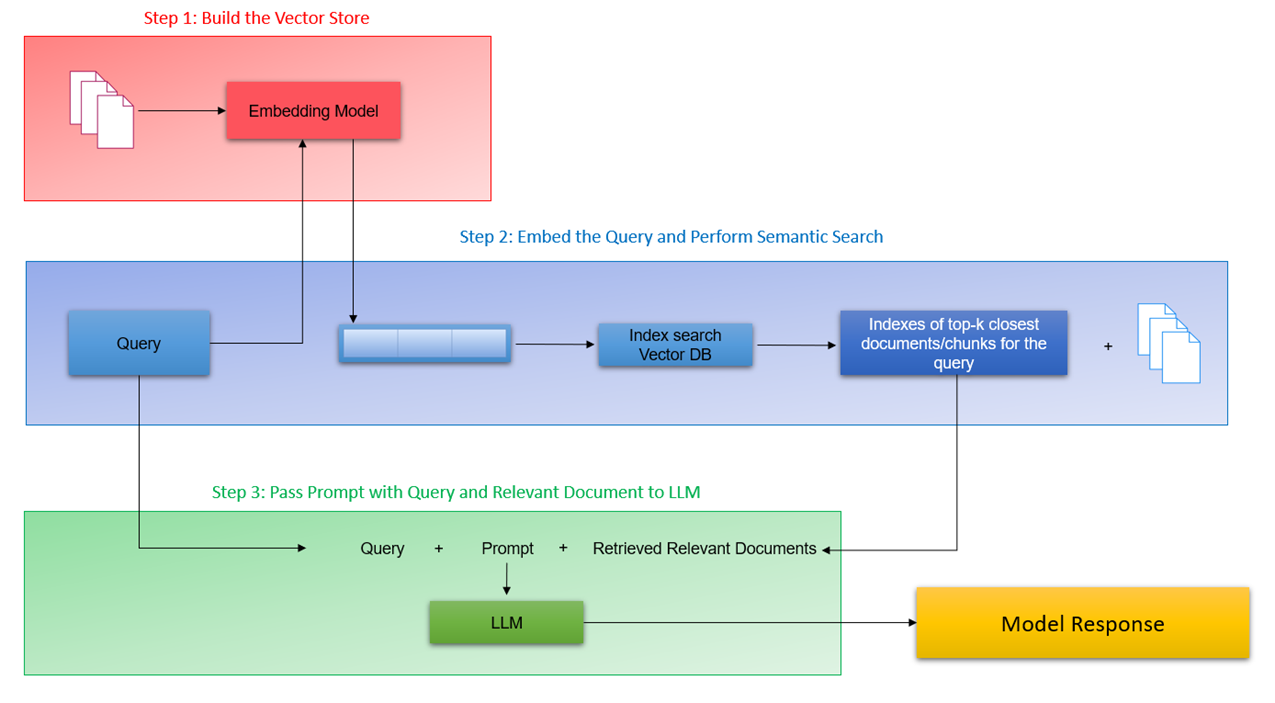

## 1. <font color = navy> Install and Import the Required Libraries

In [1]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromadb sentence-transformers -q

In [2]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb
import os

First Step:

Embedding Layer

Embedding layer - is not straight forward. First from text corpus to processing documents -- has a lot of pre-processing.

we process the documents (in this case, the documents pertain to the insurance domain) to extract the text, split it into smaller chunks and then pass them to the embedding model.

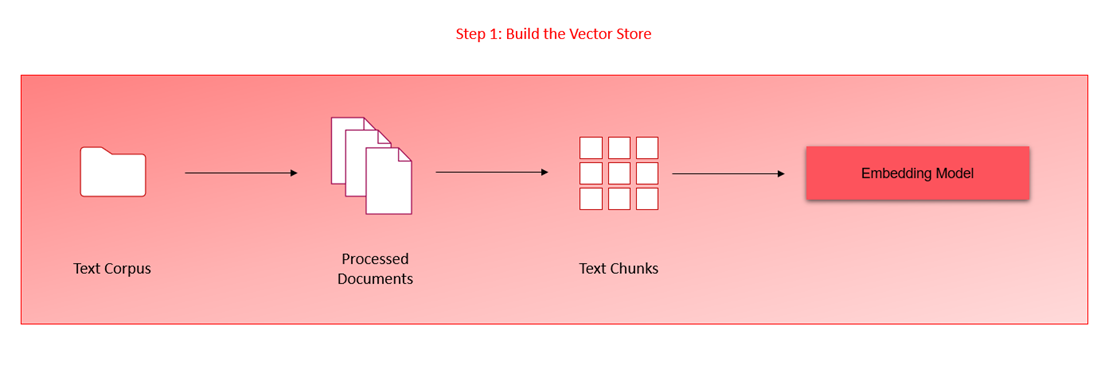

## 2. <font color = navy> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [3]:
cwd = os.getcwd()
input_path = f"{cwd}/doc"

# Define the path of the PDF
single_pdf_path = f"{input_path}/Principal-Sample-Life-Insurance-Policy.pdf"

#### <font color = navy>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [4]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # print("Table", tables)
    
    # Print the extracted text
    print(text)


Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

#### <font color = navy> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [5]:
# Define the path where all pdf documents are present

pdf_path = f"{input_path}/"

In [6]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [7]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [8]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [9]:
# Concatenate all the DFs in the list 'data' together
insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [10]:
# Check one of the extracted page texts to ensure that the text has been correctly read
# insurance_pdfs_data.Page_Text[0]


In [11]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop
insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [12]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
# insurance_pdfs_data

In [13]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = navy> Reading API Keys

In [14]:
# Set the API key
filepath = "/upgrad/OpenAPI/"

GenAIpath = filepath + "GenAIText.txt"
print(GenAIpath)
with open(GenAIpath, "r") as f:
  openai.api_key = ' '.join(f.readlines())

# with open(filepath + "HuggingFace_API_Key.txt", "r") as f:
#   huggingface_key = ' '.join(f.readlines())




/upgrad/OpenAPI/GenAIText.txt


## 4. <font color = navy> The Embedding Layer

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [15]:
# Import the OpenAI Embedding Function into chroma
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [16]:
import chromadb

In [17]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [18]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)


In [19]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [20]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [21]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

In [22]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.24228799e-02,  1.87183432e-02, -2.72361692e-02, ...,
         -3.69149223e-02,  2.83710100e-03, -1.30930578e-03],
        [-1.32057490e-02,  8.82212631e-03, -4.67860838e-03, ...,
         -1.56548154e-02, -4.84764605e-05,  7.25115696e-03],
        [-1.24035338e-02,  1.34377144e-02, -2.85228249e-03, ...,
         -2.97525711e-02, -1.01760682e-02,  9.71201342e-03]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Gri

In [23]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [24]:
# cache_collection.peek()

once the text in the documents has been pre-processed and chunked, the next step is to generate vector representations using a suitable text embedding model. So far, you have been using the sentence transformer library and, specifically, the all-MiniLM-L6-V2 model to generate vector embeddings. For this demonstration, the embedding model being used is OpenAI's embedding model - specifically, the ada002 v2 model, which embeds text into a vector of 1,536 dimensions. We are using ChromaDB’s utilities functions to generate the vector embeddings through OpenAI’s model. For more information on this, refer to :

https://docs.trychroma.com/embeddings#openai


Once the embeddings have been generated, the next step is to store them in the vector database, which is ChromaDB. As covered in the previous sessions on ChromaDB, you need to first create the Chroma collections before you can start adding documents. Akshay used the get_or_create_collections method, which will create a collection if not already present, and fetch it from your system if it has been created and stored previously. Next, since we are using OpenAI embeddings and not Chroma's default embedding, you need to also pass your embedding function as an argument while creating the collection. Finally, the information that includes the document list, text and metadata information is passed to the chroma collection. Additionally, Akshay also created a Chroma collection to serve as cache, which we will explore in the upcoming segment.

https://medium.com/@azhar.sayyad6/a-step-by-step-guide-to-parsing-pdfs-using-the-pdfplumber-library-in-python-c12d94ae9f07#:~:text=pdfplumber%20is%20a%20powerful%20library,data%20analysis%20and%20automation%20tasks.

Semantic Search Layer

As with any good system design, we need to consider a scenario when the application is scaled - suppose the number of documents increases or multiple users are using the application. Such a scenario opens up multiple concerns about the system’s performance

- How will the system handle multiple queries simultaneously?
- Is there scope to improve the system’s overall performance in search and retrieval?



The first concern can be solved by using vector databases and scaling up the compute units (clusters/server) for the application. For the second concern, an improvement to the overall system design is required which can be achieved by implementing a cache collection in the vector database that stores previous queries and their results in the vector database. Let’s hear more on this from Akshay in the video below.

System Design of Semantic Search Layer:

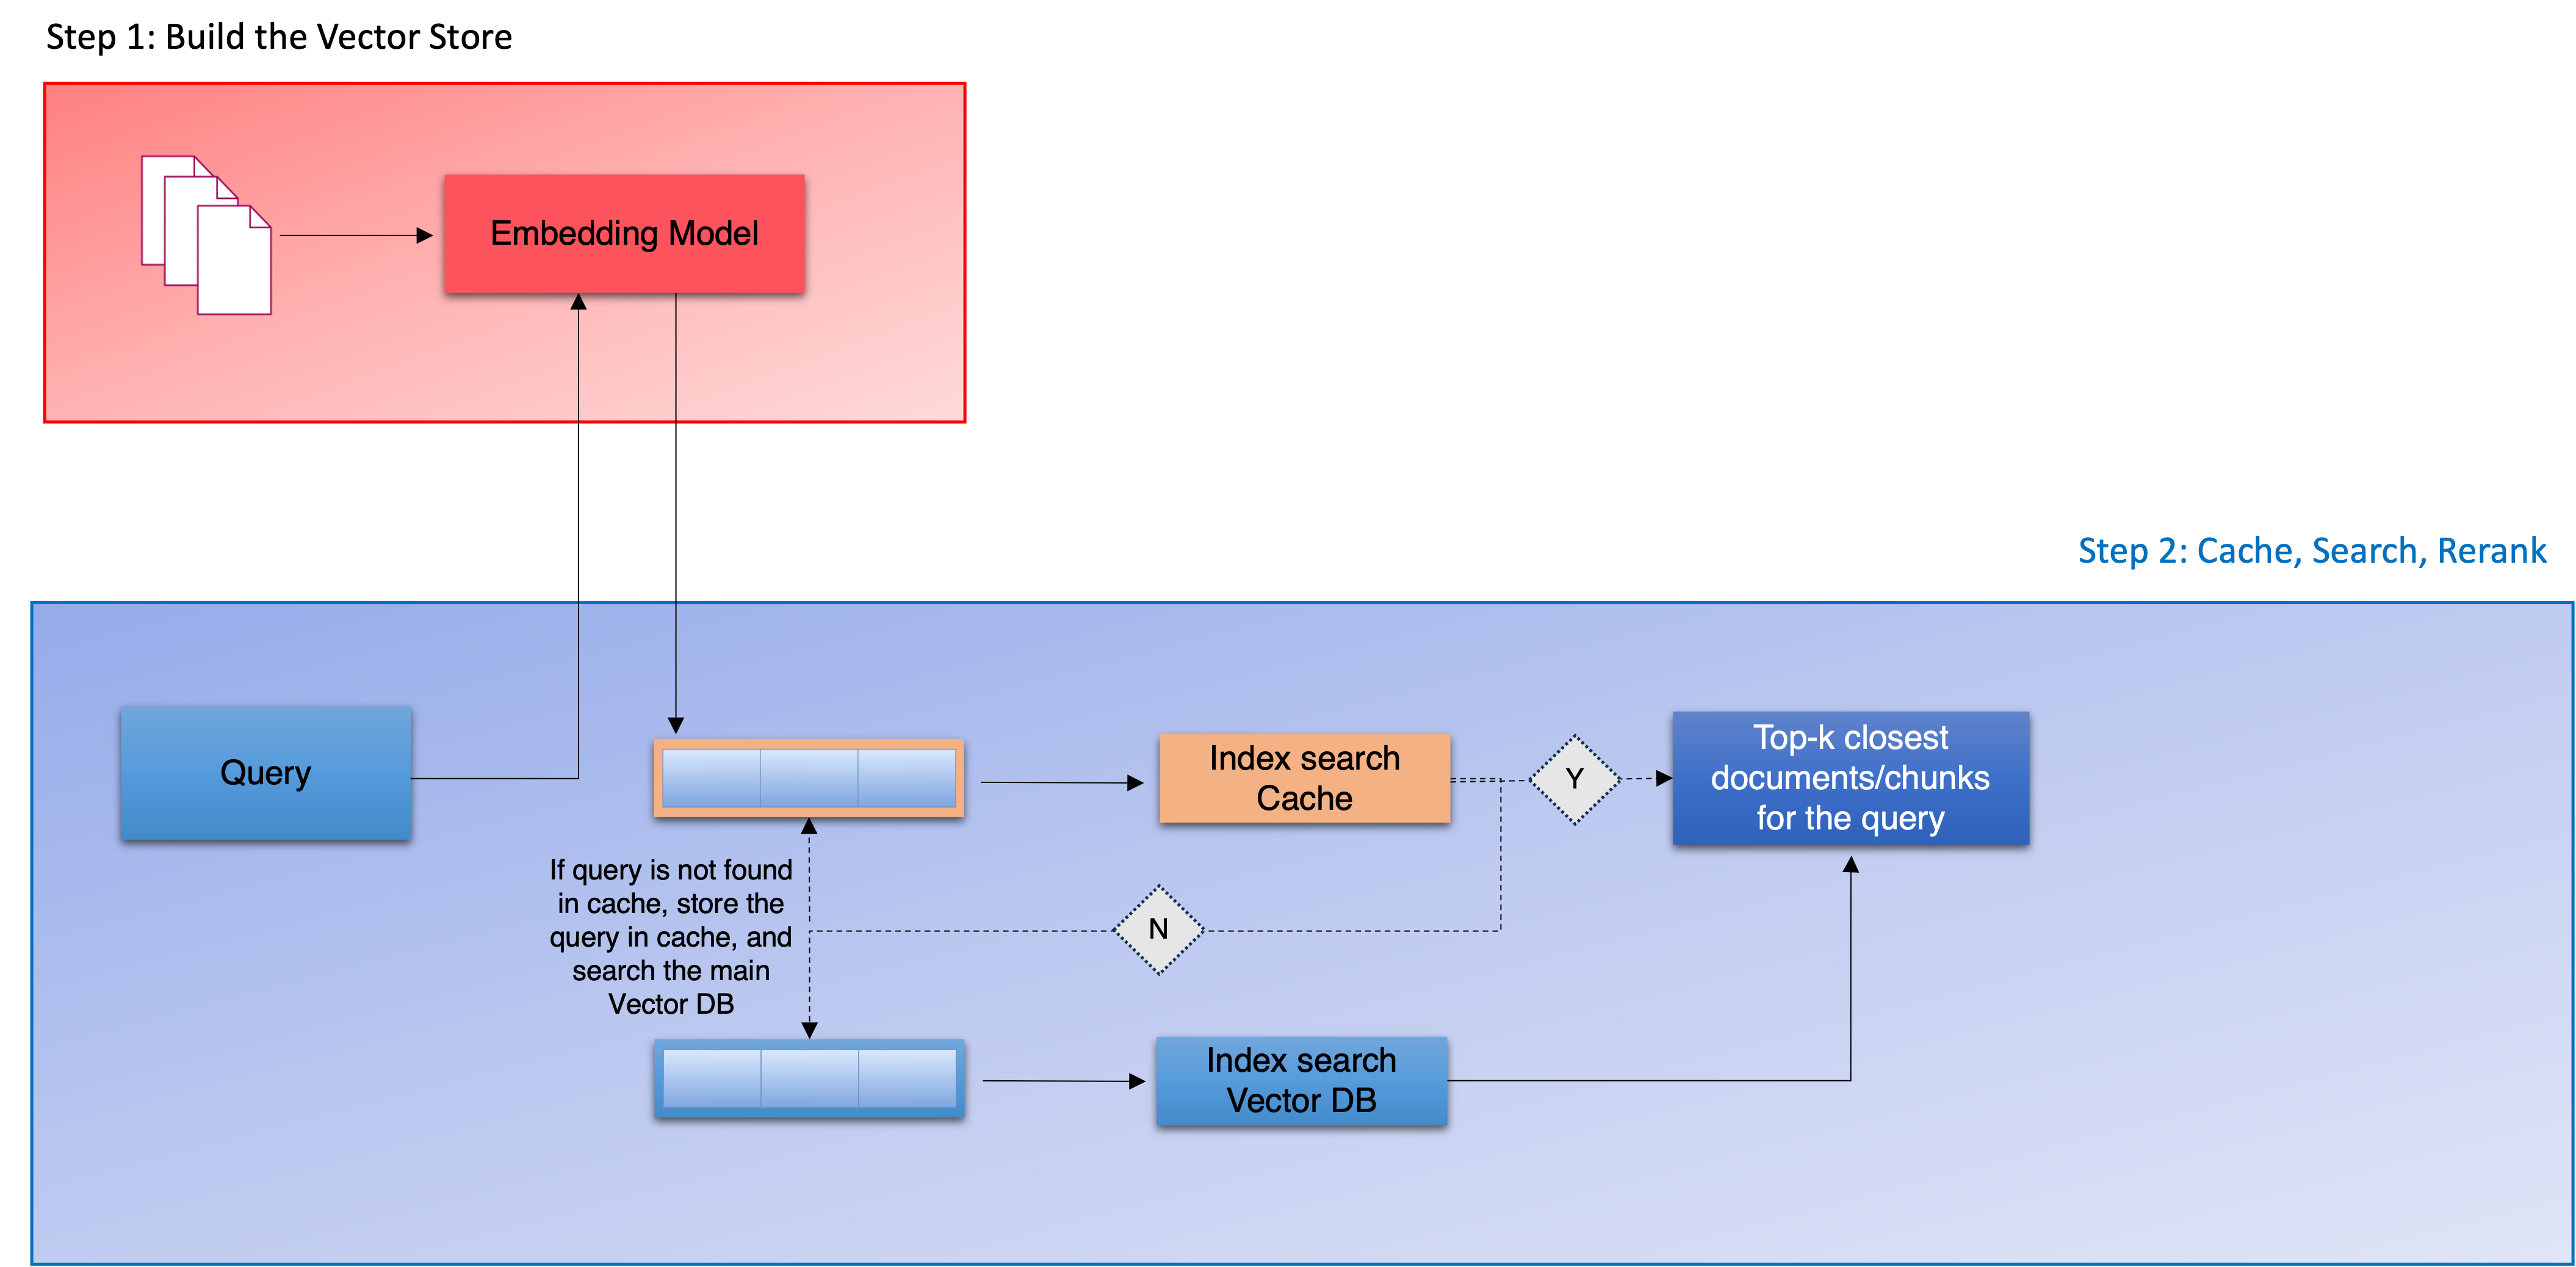

## 5. <font color = navy> The Search Layer

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [25]:
# Read the user query
def semantic_search_cache(query):
    # print(query)
    cache_results = cache_collection.query(
        query_texts=query,
        n_results=1
    )
    results = insurance_collection.query(
        query_texts=query,
        n_results=10
    )
    # Implementing Cache in Semantic Search
    
    # Set a threshold for cache search
    threshold = 0.2
    
    ids = []
    documents = []
    distances = []
    metadatas = []
    results_df = pd.DataFrame()
    
    
    # If the distance is greater than the threshold, then return the results from the main collection.
    
    if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
          # Query the collection against the user query and return the top 10 results
          results = insurance_collection.query(
          query_texts=query,
          n_results=10
          )
    
          # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
          # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
          Keys = []
          Values = []
    
          for key, val in results.items():
            if val is None:
              continue
            for i in range(10):
              try:
                Keys.append(str(key)+str(i))
              except:
                  pass
              try:
                  Values.append(str(val[0][i]))
              except:
                      pass
            
    
          cache_collection.add(
              documents= [query],
              ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
              metadatas = dict(zip(Keys, Values))
          )
    
          print("Not found in cache. Found in main collection.")
    
          result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
          results_df = pd.DataFrame.from_dict(result_dict)
          results_df
    
    
    # If the distance is, however, less than the threshold, you can return the results from cache
    
    elif cache_results['distances'][0][0] <= threshold:
          cache_result_dict = cache_results['metadatas'][0][0]
    
          # Loop through each inner list and then through the dictionary
          for key, value in cache_result_dict.items():
              if 'ids' in key:
                  ids.append(value)
              elif 'documents' in key:
                  documents.append(value)
              elif 'distances' in key:
                  distances.append(value)
              elif 'metadatas' in key:
                  metadatas.append(value)
    
          # print("Found in cache!")
    
          # Create a DataFrame
          results_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
          })
    return results_df


## 6. <font color = navy> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

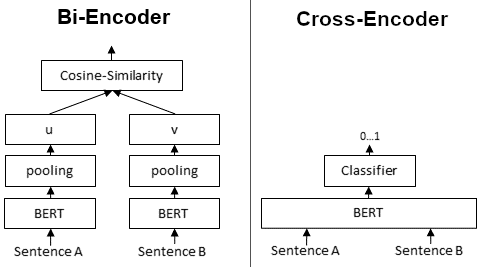

<br>

 the re-ranking stage is the next step in building the semantic search pipeline. So far, in our semantic search application, the system returns the top K documents that contain information relevant to the user’s query. The quality and accuracy of the information contained in these chunks or documents may vary - the system might retrieve documents that are not quite relevant to the search query. The purpose of the re-ranking layer is to sift through these top K results, verify the accuracy of the results in terms of the query and rank them or assign an importance score to these results for the query. Here are some of the benefits of using re-ranking in generative search:
- Improved accuracy and relevance of the generated results
- Reduced amount of irrelevant or inaccurate information presented to the user
- More personalised and informative search results
- Ability to tailor the search results to specific tasks or domains



Traditionally, many methods of re-rank methods have been used in search such as Reciprocal Rank Fusion (RRF), hybrid search methods and cross-encoder models. For this project, we will focus on the popular method of using cross-encoders for our re-ranking task. The image below illustrates the re-ranking component once the search results have been collected by the semantic search layer.

Search - with Cross Encoders System Design

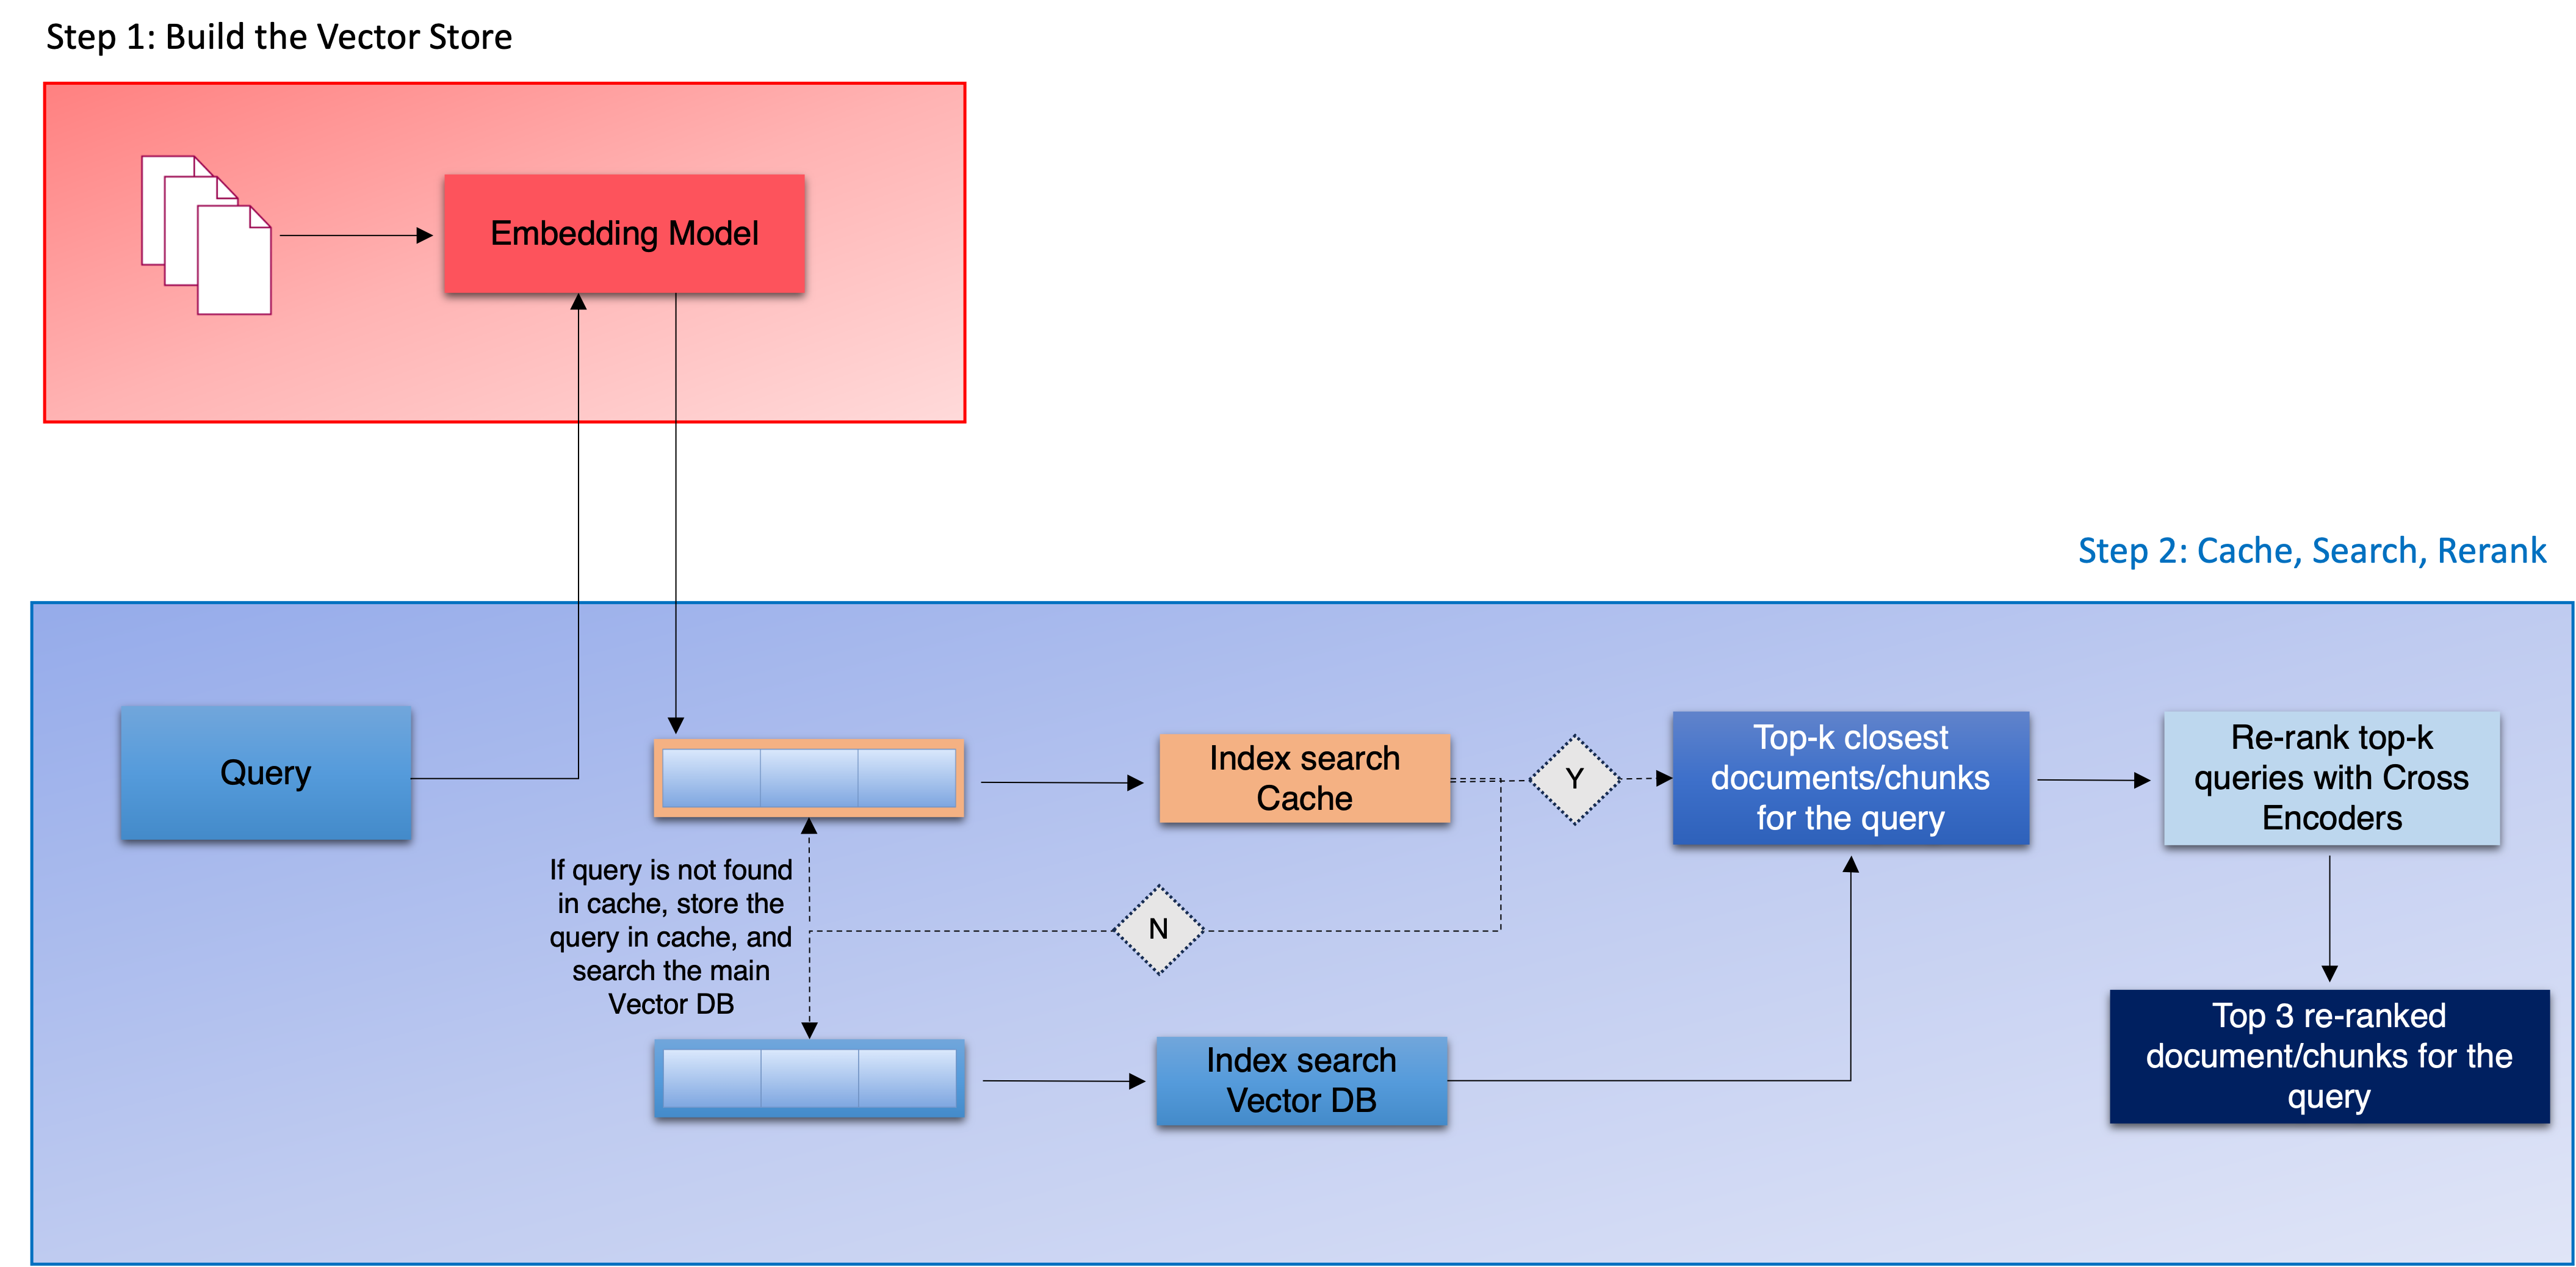

In [26]:
# # Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

# # Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')


In [27]:
def semantic_search_rerank(results_df):
    # Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
    # Generate the cross_encoder scores for these pairs
    
    cross_inputs = [[query, response] for response in results_df['Documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)

    # Store the rerank_scores in results_df
    
    results_df['Reranked_scores'] = cross_rerank_scores
    
    # Return the top 3 results from semantic search    
    top_3_semantic = results_df.sort_values(by='Distances')
    

    # Return the top 3 results after reranking    
    top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)

    top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

    return top_3_RAG
    
    

Generation Layer System Design

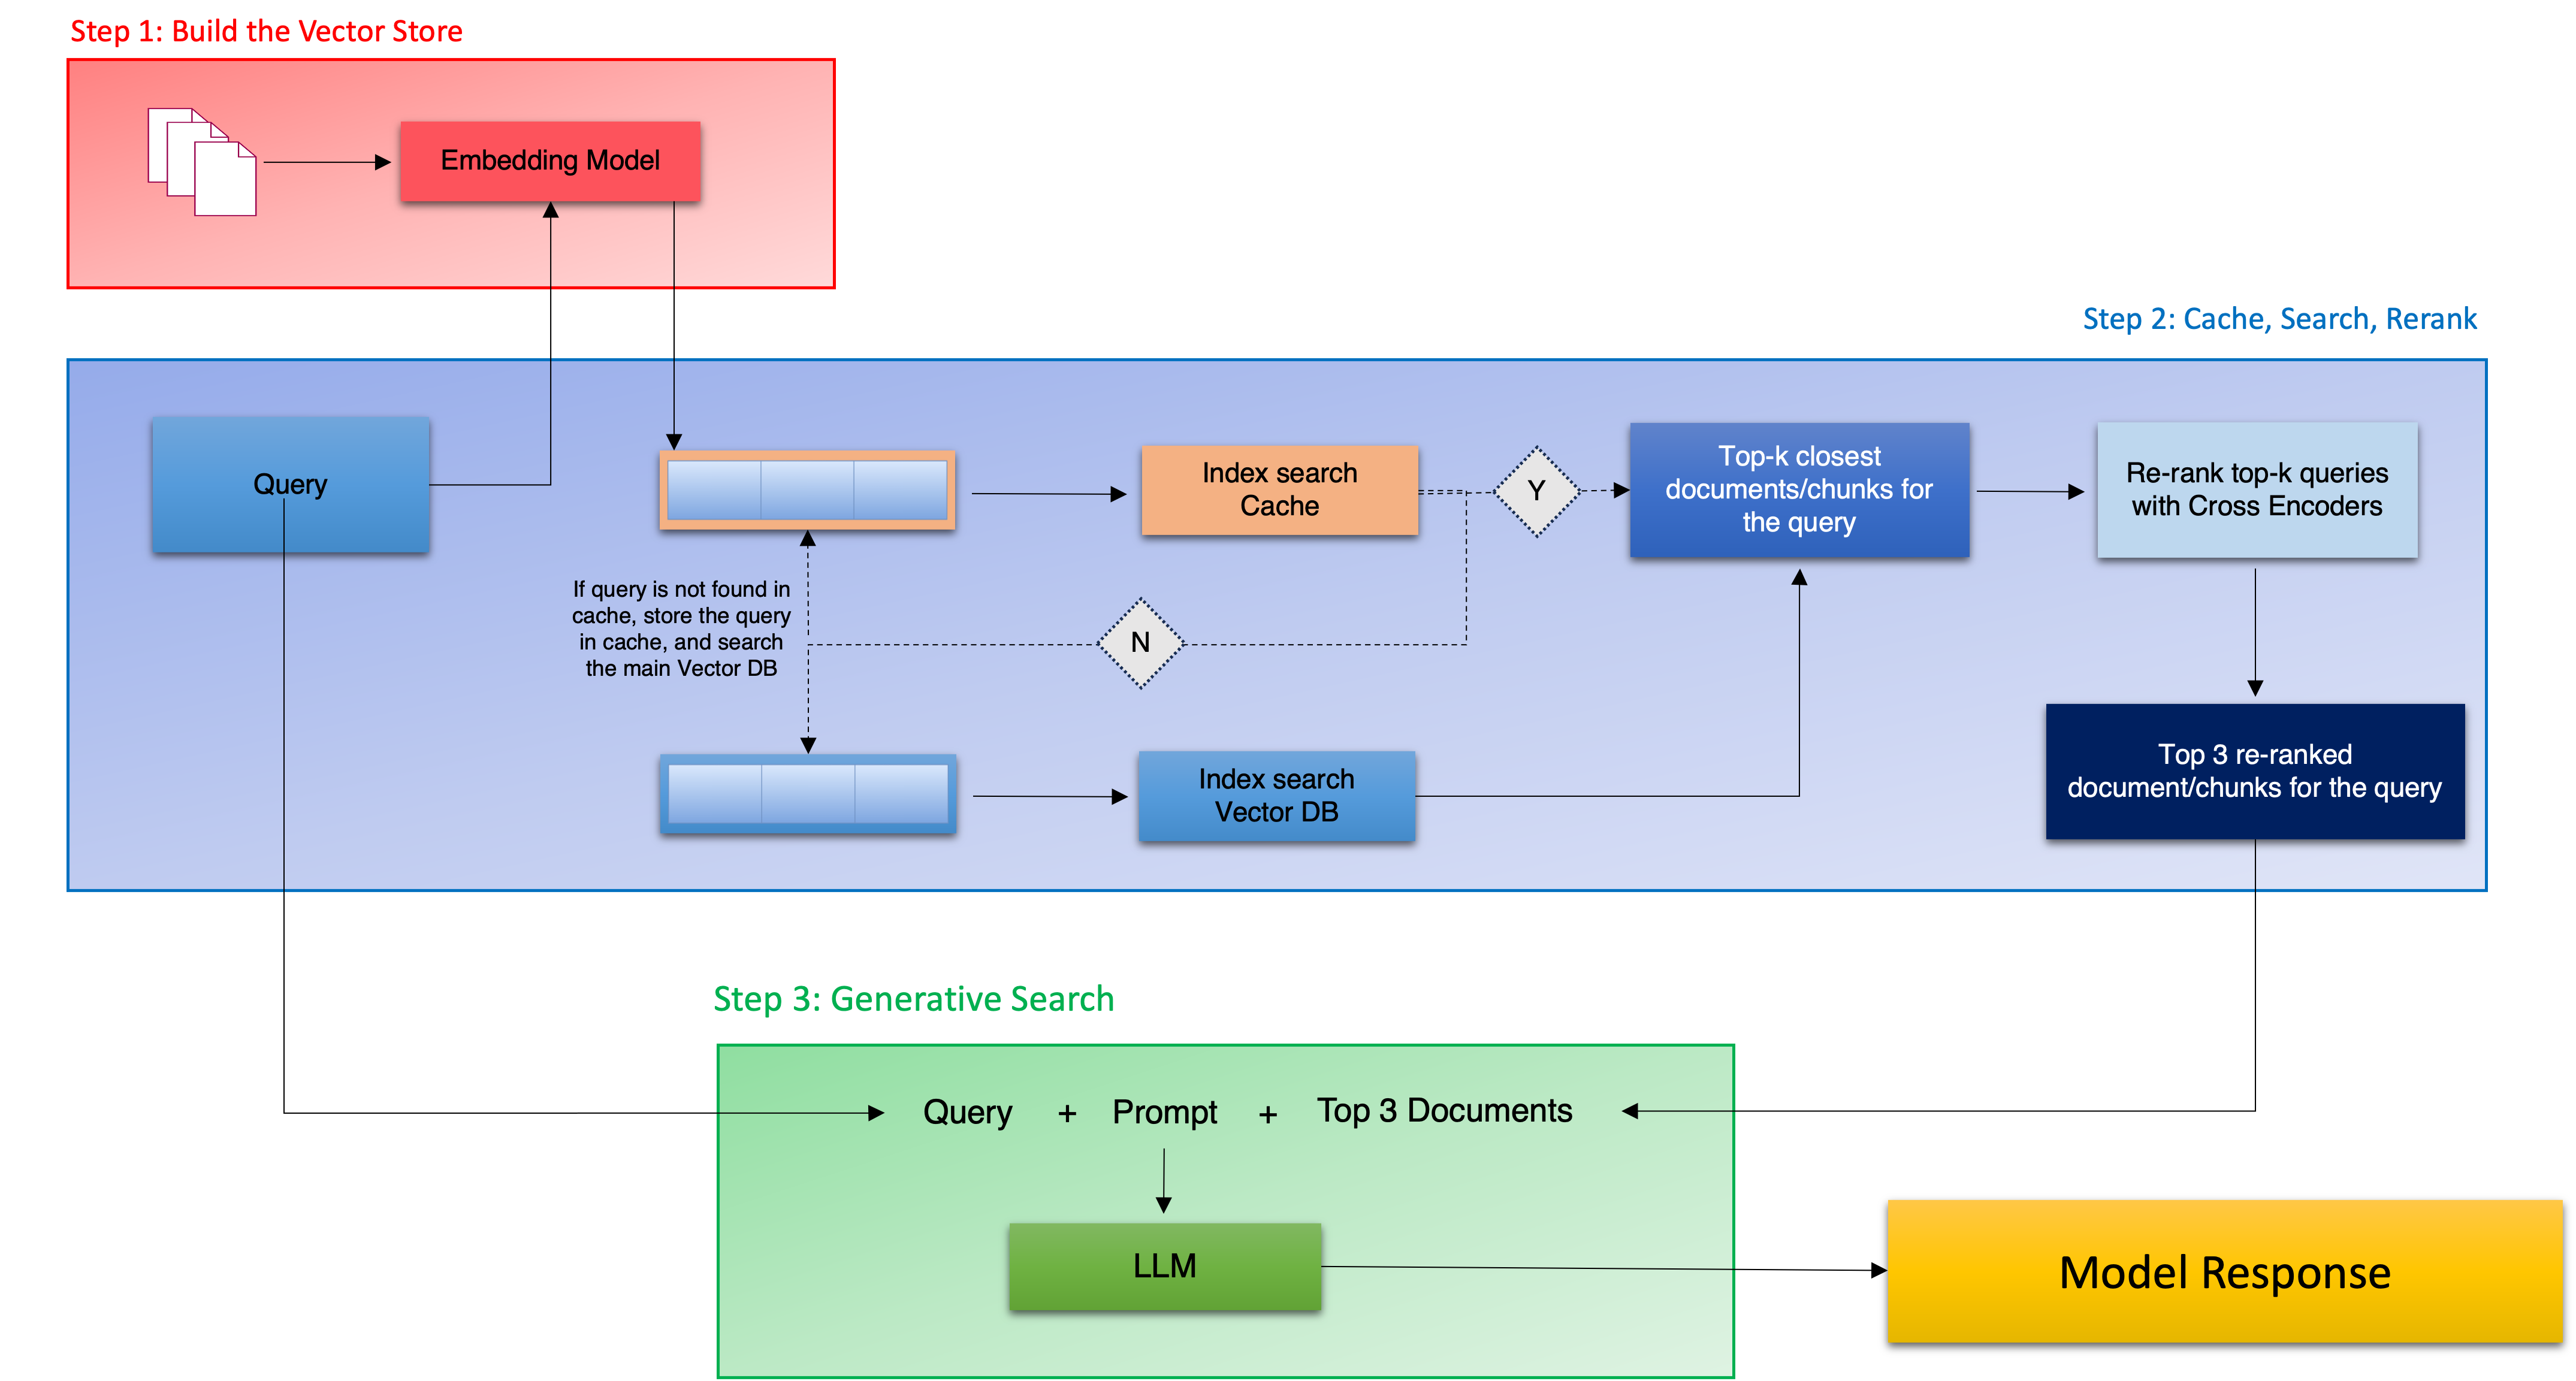

## 7. <font color = navy> The Generation Layer

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [28]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""

You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
A user ask you a question like this : '{query}'.

You have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially coming from a 1 pages of an insurance document that may be relevant to the user query. The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row. 

Use the documents in '{top_3_RAG}' to answer the query '{query}'. 

Frame an informative answer and also, use the dataframe to return following:
1) The relevant policy names.
2) Page numbers as citations
3) Actual text.


Follow the guidelines below when performing the task.
1. Try to provide relevant/accurate numbers if available.
2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
4. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
5. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
6. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.
7. Dont truncate any text, show complete text

The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.



                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

## 8. <font color = navy> Testing above RAG model  

Testing the above RAG model means checking how well it sorts and handles different parts of a project based on their status. 

In [31]:
question_list = [    
    "What happens if complete amount is exhausted?",
    "What are the policy terms in case a person dies due to alcohol consumption",
    "What is policy terms in case of a medicine reaction?",
    "What are the policy terms in case a person dies during a adventure sport activity?",
    "Person will be eligible for Member Life Insurance at what age?",
    "What is the process for contesting a claim denial by the insurance company?",
    "How can I change the beneficiaries listed in this policy, if needed?",
    "What is the eligibility age of physically Handicapped Children?",
    "How about death during Medical Examinations"
]




In [30]:
for query in question_list:
    results_df = semantic_search_cache(query)    
    top_3_RAG = semantic_search_rerank(results_df)
    print("\n\n\n\nQuestion:- ", query)    
    print("\n\n**Top 3 RAG Results:**")
    pd.set_option('display.max_colwidth', 150)
    pd.set_option('display.max_columns', None)
    display(top_3_RAG)
    response = generate_response(query, top_3_RAG)    
    # Display the response
    display("The Generated Response")
    print("\n".join(response))
    print("\n|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----")
    





Question:-  What happens if complete amount is exhausted?


**Top 3 RAG Results:**


,Documents,Metadatas
6,% of Scheduled Covered Loss Benefit Loss of Speech and/or Hearing Speech and Hearing 100% Speech or Hearing 50% Hearing in One Ear 25% Loss must b...,"{'Page_No.': 'Page 57', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
3,"c . If a beneficiary dies at the same time or within 15 days after the Member dies, but before The Principal receives Written proof of the Member'...","{'Page_No.': 'Page 48', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
4,"If a Member sustains an injury, and as a result of such injury, one or more of the covered losses listed below are incurred, The Principal will pa...","{'Page_No.': 'Page 56', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"


'The Generated Response'

The amount available in an insurance policy is considered exhausted when all covered losses or benefits have been paid out. When this happens, the policy will no longer provide any additional coverage or benefits.

Here is the information from the relevant insurance policy document that may provide more details:

**Policy Name:** Principal-Sample-Life-Insurance-Policy  
**Page Number:** Page 57  

**Actual Text:**  
% of Scheduled Covered Loss Benefit Loss of Speech and/or Hearing Speech and Hearing 100%  
Speech or Hearing 50%  
Hearing in One Ear 25%  
Loss must b...

In this specific section of the policy document, there is a description of the coverage provided for loss of speech and/or hearing, including the percentage of benefit provided based on the type of loss incurred.

Please refer to Page 57 of the Principal-Sample-Life-Insurance-Policy document for more information regarding what happens if the complete amount is exhausted.

---

**Citations:**  
Policy Name: Principal-Sam

,Documents,Metadatas
0,"a. willful self-injury or self-destruction, while sane or insane; or b. disease, medical or surgical treatment of disease, or complications follow...","{'Page_No.': 'Page 58', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
1,"M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member...","{'Page_No.': 'Page 47', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
5,Exposure Exposure to the elements will be presumed to be an injury if: a. such exposure is due to an accidental bodily injury; and b. within 365 d...,"{'Page_No.': 'Page 55', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"


'The Generated Response'

Based on the provided insurance documents, the query regarding the policy terms in case a person dies due to alcohol consumption is irrelevant. As per the documents, the discussed scenarios are related to willful self-injury or self-destruction, diseases, medical or surgical treatments, complications following an injury, exposure to the elements, and death benefits under specific circumstances. No specific information regarding death due to alcohol consumption is mentioned in the extracted content.

If you are looking for information on death due to alcohol consumption in insurance policies, it would be advisable to directly refer to the specific policy sections on exclusions, cause of death, or any clauses related to alcohol intake and its impact on coverage.

While the search did not yield relevant information for your query, in order to have a more accurate insight on this topic, you may want to refer to the mentioned pages from the 'Principal-Sample-Life-Insurance-Policy' document:

,Documents,Metadatas
0,a . A licensed Doctor of Medicine (M.D.) or Osteopathy (D.O.); or b. any other licensed health care practitioner that state law requires be recogn...,"{'Page_No.': 'Page 13', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
9,"b . on any date the definition of Member or Dependent is changed; and c. on any date the Policyholder's business, as specified on the Policyholder...","{'Page_No.': 'Page 21', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
2,A claimant may request an appeal of a claim denial by Written request to The Principal within 180 days of receipt of notice of the denial. The Pri...,"{'Page_No.': 'Page 62', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"


'The Generated Response'

**Response:**

In case of a medicine reaction, the policy terms may vary depending on the specific insurance policy that you have. It is recommended to refer to your policy document for detailed information on how medicine reactions are covered and what steps need to be followed to make a claim. If you are experiencing a medicine reaction, it is advisable to consult a healthcare provider immediately and inform your insurance company as soon as possible.

**Relevant Policy Name:** Principal-Sample-Life-Insurance-Policy

**Page Numbers (citations):** Page 13, Page 21, Page 62

**Actual Text (excerpt):**
- **Policy Name:** Principal-Sample-Life-Insurance-Policy
- **Page 13:**  
"a . A licensed Doctor of Medicine (M.D.) or Osteopathy (D.O.); or b. any other licensed health care practitioner that state law requires be recogn..."
- **Page 21:**  
"b . on any date the definition of Member or Dependent is changed; and c. on any date the Policyholder's business, as specified on the Policyholder

,Documents,Metadatas
1,"a. willful self-injury or self-destruction, while sane or insane; or b. disease, medical or surgical treatment of disease, or complications follow...","{'Page_No.': 'Page 58', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
2,"M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member...","{'Page_No.': 'Page 47', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
5,"I f a Dependent who was insured dies during the 31-day individual purchase period described in PART III, Section F, Article 2, The Principal will ...","{'Page_No.': 'Page 60', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"


'The Generated Response'

**Response:**

In cases where a person dies during an adventure sport activity, the following policy terms may be applicable based on the insurance document:

1. The insurer may withhold Death Benefits Payable until additional information has been received or a trial has been held. If the deceased individual was insured as a Member, this clause may be invoked (Principal-Sample-Life-Insurance-Policy, Page 47).

Below is the detailed text extract related to the policy terms:
- Member's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member... (Principal-Sample-Life-Insurance-Policy, Page 47)

**Citations:**
- Policy Name: Principal-Sample-Life-Insurance-Policy
- Page Number(s): Page 47

----

**Full Extracted Text:**

**Document Extract (Page 47 - Principal-Sample-Life-Insurance-Policy):**
"Member's death, the Death Benefits Payable may be withheld until additional information has been received or the trial

,Documents,Metadatas
0,PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS Section A - Eligibility Article 1 - Member Life Insurance A person will be eligible for Member Life ...,"{'Page_No.': 'Page 26', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
1,"Section F - Individual Purchase Rights Article 1 - Member Life Insurance a. Individual Policy If a Member qualifies and makes timely application, ...","{'Page_No.': 'Page 42', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
2,(4) Premium will be based on the Dependent's age and the standard rate of The Principal for the policy form to be issued. b. Purchase Qualificatio...,"{'Page_No.': 'Page 44', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"


'The Generated Response'

Based on the information from the insurance documents, a person will be eligible for Member Life Insurance according to the below details retrieved from the policy named "Principal-Sample-Life-Insurance-Policy" on page 26:

| Eligibility Criteria                                          | Min. Age | Max. Age |
|---------------------------------------------------------------|----------|----------|
| Member Life Insurance Eligibility Age                         | 18 years | --       |

Therefore, an individual will be eligible for Member Life Insurance starting from 18 years of age.

---
**Citations:**
- Relevant Policy Name: Principal-Sample-Life-Insurance-Policy
- Page Number: Page 26

---

The actual text extracted from the document:

**PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS**
**Section A - Eligibility**
**Article 1 - Member Life Insurance**

"A person will be eligible for Member Life Insurance at 18 years of age."

This information is retrieved from the insurance document "Pri

,Documents,Metadatas
0,A claimant may request an appeal of a claim denial by Written request to The Principal within 180 days of receipt of notice of the denial. The Pri...,"{'Page_No.': 'Page 62', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
1,Section D - Claim Procedures Article 1 - Notice of Claim Written notice must be sent to The Principal by or for a Member or Dependent who wishes t...,"{'Page_No.': 'Page 61', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
6,"The Principal may require that a ADL Disabled or Totally Disabled Member be examined by a Physician or undergo an evaluation, at reasonable interv...","{'Page_No.': 'Page 50', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"


'The Generated Response'

The process for contesting a claim denial by the insurance company involves submitting a written request to The Principal within 180 days of receiving the notice of denial. The request should be an appeal of the claim denial.

Here is the relevant information from the insurance document:
- Policy Name: Principal-Sample-Life-Insurance-Policy
- Citation: Page 62
- Actual Text:
"A claimant may request an appeal of a claim denial by Written request to The Principal within 180 days of receipt of notice of the denial. The Pri..."

I recommend reviewing page 62 of the Principal-Sample-Life-Insurance-Policy document for more detailed information on contesting claim denials.

---

**Citations:**
1. Policy Name: Principal-Sample-Life-Insurance-Policy
2. Page Number: Page 62

**Actual Text:**
"A claimant may request an appeal of a claim denial by Written request to The Principal within 180 days of receipt of notice of the denial. The Pri..."

|-----|-----|-----|-----|-----|-----|-----|-----|-----

,Documents,Metadatas
0,"M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member...","{'Page_No.': 'Page 47', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
2,"I f a Dependent who was insured dies during the 31-day individual purchase period described in PART III, Section F, Article 2, The Principal will ...","{'Page_No.': 'Page 60', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
1,c . a copy of the form which contains the statement is given to the insured or the insured's beneficiary at the time insurance is contested. Howev...,"{'Page_No.': 'Page 18', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"


'The Generated Response'

To change the beneficiaries listed in the policy, you need to follow the instructions provided in the policy document "Principal-Sample-Life-Insurance-Policy" on Page 47. The process and requirements for changing beneficiaries will be detailed in that section of the policy document. It is essential to review the specific guidelines outlined to ensure that the beneficiary changes are processed correctly.

Text from the relevant policy document:
"Member's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member..."

Citations:
1) Policy Name: Principal-Sample-Life-Insurance-Policy
2) Page Number: Page 47

|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----




Question:-  What is the eligibility age of physically Handicapped Children?


**Top 3 RAG Results:**


,Documents,Metadatas
0,(1) the child is incapable of self-support as the result of a Developmental Disability or Physical Handicap and became so before reaching the maxi...,"{'Page_No.': 'Page 39', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
2,Section D - Continuation Article 1 - Member Life Insurance a. Sickness or Injury (Other Than ADL Disability or Total Disability) If Active Work en...,"{'Page_No.': 'Page 38', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
6,"Payment of benefits will be subject to the Beneficiary and Facility of Payment provisions of this PART IV, Section A. Article 6 - Member Life Insu...","{'Page_No.': 'Page 49', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"


'The Generated Response'

The eligibility age of physically handicapped children is determined when the child becomes incapable of self-support as a result of a Developmental Disability or Physical Handicap, and this must occur before reaching a certain age specified in the insurance policy document.

To provide more detailed information and assist you further, the following policy document can be referenced:
- Policy Name: Principal-Sample-Life-Insurance-Policy
- Page Number: Page 39

Relevant Text from the Policy Document:
```
(1) the child is incapable of self-support as the result of a Developmental Disability or Physical Handicap and became so before reaching the maximum eligibility age specified in the policy...
```

In this document, specific details about the eligibility age criteria for physically handicapped children can be found on page 39. Please refer to this section for more detailed information on eligibility requirements for physically handicapped children.

_References:_
Policy Name: Principal-

,Documents,Metadatas
5,"Payment of benefits will be subject to the Beneficiary and Facility of Payment provisions of this PART IV, Section A. Article 6 - Member Life Insu...","{'Page_No.': 'Page 49', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
0,"The Principal may require that a ADL Disabled or Totally Disabled Member be examined by a Physician or undergo an evaluation, at reasonable interv...","{'Page_No.': 'Page 50', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"
6,Coverage During Disability will cease on the earliest of: (1) the date the Member's Total Disability ends; or (2) the date the Member fails to sen...,"{'Page_No.': 'Page 51', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}"


'The Generated Response'

The insurance policy "Principal-Sample-Life-Insurance-Policy" addresses coverage during disability, but it does not specifically mention death during medical examinations. The information provided in the document does not directly relate to the query about death during medical examinations.

Please refer to the relevant clauses in the insurance policy documentation for detailed information on death during medical examinations.

**Citations:**

1) Policy Name: Principal-Sample-Life-Insurance-Policy
2) Page Numbers: 
   - Page 49
   - Page 50
   - Page 51

**Text from Relevant Documents:**
1) Payment of benefits will be subject to the Beneficiary and Facility of Payment provisions of this PART IV, Section A. Article 6 - Member Life Insurance.

2) The Principal may require that an ADL Disabled or Totally Disabled Member be examined by a Physician or undergo an evaluation, at reasonable intervals.

3) Coverage During Disability will cease on the earliest of: 
   - the date the Member's Tot